<a href="https://colab.research.google.com/github/dinhquy-nguyen-1704/NguyenDinhQuy_01/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd ''

In [ ]:
! pip install facenet-pytorch

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as dutils
from facenet_pytorch import MTCNN, InceptionResnetV1
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
import warnings
warnings.simplefilter("ignore")

In [ ]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
mtcnn = MTCNN(image_size=160, margin = 0, device = device, min_face_size=20) # initializing mtcnn for face detection

In [ ]:
X_train, X_val, X_test = [], [], []
y_train, y_val, y_test = [], [], []
data_folder = ""

for folder in os.listdir(data_folder):
  curr_path = os.path.join(data_folder, folder)
  X_temp = []
  y_temp = []
  for pic_file in os.listdir(curr_path):
    curr_file = os.path.join(curr_path, pic_file)
    X_temp.append(curr_file)
    y_temp.append(folder)

  # for each folder, split the images in it into train, test, split set
  X_train_val_temp, X_test_temp, y_train_val_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size = 0.2, shuffle = True)
  X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_train_val_temp, y_train_val_temp, test_size = 0.375, shuffle = True)

  X_train += X_train_temp
  X_val += X_val_temp
  X_test += X_test_temp

  y_train += y_train_temp
  y_val += y_val_temp
  y_test += y_test_temp

In [ ]:
# Encode label
label_encoder = preprocessing.LabelEncoder()
y_train_encode = label_encoder.fit_transform(y_train)
y_val_encode = label_encoder.transform(y_val)
y_test_encode = label_encoder.transform(y_test)

y_train_encode = torch.Tensor(y_train_encode)
y_val_encode = torch.Tensor(y_val_encode)
y_test_encode = torch.Tensor(y_test_encode)

In [ ]:
# Use mtcnn to cut human faces
X_train_set = []
for path in X_train:
  img = Image.open(path)
  face = mtcnn(img, return_prob = False)
  X_train_set.append(face)

X_val_set = []
for path in X_val:
  img = Image.open(path)
  face = mtcnn(img, return_prob = False)  
  X_val_set.append(face)

X_test_set = []
for path in X_test:
  img = Image.open(path)
  face = mtcnn(img, return_prob = False) 
  X_test_set.append(face)                        

In [ ]:
train_set = list(zip(X_train_set, y_train_encode))
val_set = list(zip(X_val_set, y_val_encode))
test_set = list(zip(X_test_set, y_test_encode))
print(len(train_set))
print(len(val_set))
print(len(test_set))

In [ ]:
train_set = [i for i in train_set if i[0] is not None]
val_set = [i for i in val_set if i[0] is not None]
test_set = [i for i in test_set if i[0] is not None]
print(len(train_set))
print(len(val_set))
print(len(test_set))

In [ ]:
#torch.save(train_set, 'train_set_3.pt')
#torch.save(val_set, 'val_set_3.pt')
#torch.save(test_set, 'test_set_3.pt')

train_set = torch.load('train_set_3.pt')
val_set = torch.load('val_set_3.pt')
test_set = torch.load('test_set_3.pt')

In [ ]:
batch_size = 32
train_loader = dutils.DataLoader(train_set, batch_size = batch_size, shuffle = True, drop_last = True)
val_loader = dutils.DataLoader(val_set, batch_size = batch_size, shuffle = True, drop_last = False)

In [ ]:
# freeze_layers function
def freeze_layers(model, freezed_layers):
    child_count = 0
    for child in model.children():
        child_count += 1
        if child_count < (freezed_layers + 1):
            for param in child.parameters():
                param.requires_grad = False
            print("child ", child_count, " was frozen")
    return model

In [ ]:
def train(model, train_loader, val_loader, lr, epochs):
  # Put model on device
  model = model.to(device)
  # Optimization algorithm
  optimizer = optim.Adam(lr = lr, params = model.parameters())

  train_losses = []
  val_losses = []
  val_acc = []

  best_val_loss = 1e100
  best_state_dict = None

  for ei in tqdm(range(epochs)):
    train_lossi = []
    for bi, (xi, yi) in enumerate(train_loader):
      optimizer.zero_grad()
      xi = xi.to(device)
      yi = yi.type(torch.LongTensor) 
      yi = yi.to(device)
      yi_hat = model(xi)
      lossi = lossf(yi_hat, yi)
      lossi.backward()
      optimizer.step()
      train_lossi.append(lossi.item())

    val_lossi = []
    correct = 0.
    total = 0.
    with torch.no_grad():
      for bvi, (xvi, yvi) in enumerate(val_loader):
        xvi = xvi.to(device)
        yvi = yvi.type(torch.LongTensor) 
        yvi = yvi.to(device)
        yvi_hat = model(xvi)
        lossvi = lossf(yvi_hat, yvi)
        val_lossi.append(lossvi.item())
        yvi_hat = yvi_hat.argmax(dim = 1).long()
        yvi = yvi.long()
        correct += (yvi_hat == yvi).sum()
        total += yvi.size(0)
        acci = (correct / total).item()
      val_acc.append(acci)      

    train_losses.append(torch.FloatTensor(train_lossi).mean().item())
    val_losses.append(torch.FloatTensor(val_lossi).mean().item())
    if val_losses[-1] < best_val_loss:
      best_val_loss = val_losses[-1]
      best_state_dict = model.state_dict()
    tqdm.write(" train_loss %.4f; val_loss %.4f; val_acc %.4f" % (train_losses[-1], val_losses[-1], val_acc[-1]))
  model.load_state_dict(best_state_dict)  # parameters of moded

  return model, train_losses, val_losses, val_acc

In [ ]:
# Define visualize_accuracy function
def visualize_accuracy(val_acc):
    plt.plot(val_acc, color = "green", linewidth = 1)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Valid accuracy')

    plt.show()
    print("="*100)

In [ ]:
# Define visualize_losses function
def visualize_losses(train_losses, val_losses):
    plt.plot(train_losses, color = "green", linewidth = 1)
    plt.plot(val_losses, color = "purple", linestyle = "--", linewidth = 1)
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train', 'Valid'])
    plt.title('Train - valid losses')
 
    plt.show()

### DENSENET121

In [ ]:
# Load Densenet-121 model
densenet121 = models.densenet121(pretrained = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 56.5MB/s]


In [ ]:
# Freeze first layer of Densenet121
densenet121 = freeze_layers(densenet121, 1)

child  1  was frozen


In [ ]:
# Customize the final layer
densenet121.classifier = nn.Linear(1024, 14)

In [ ]:
# Define Loss function
lossf = nn.CrossEntropyLoss()

In [ ]:
lr = 1e-4
epochs = 100
model, train_losses, val_losses, val_acc = train(densenet121, train_loader, val_loader, lr = lr, epochs = epochs)

  1%|          | 1/100 [00:11<18:36, 11.27s/it]

 train_loss 2.4217; val_loss 2.1585; val_acc 0.4066


  2%|▏         | 2/100 [00:22<17:55, 10.97s/it]

 train_loss 1.9432; val_loss 1.7585; val_acc 0.6341


  3%|▎         | 3/100 [00:32<17:33, 10.86s/it]

 train_loss 1.5937; val_loss 1.4597; val_acc 0.7506


  4%|▍         | 4/100 [00:43<17:18, 10.82s/it]

 train_loss 1.3337; val_loss 1.2321; val_acc 0.8166


  5%|▌         | 5/100 [00:54<17:05, 10.79s/it]

 train_loss 1.1278; val_loss 1.0564; val_acc 0.8765


  6%|▌         | 6/100 [01:05<16:53, 10.79s/it]

 train_loss 0.9743; val_loss 0.9286; val_acc 0.8942


  7%|▋         | 7/100 [01:15<16:42, 10.78s/it]

 train_loss 0.8475; val_loss 0.8213; val_acc 0.9102


  8%|▊         | 8/100 [01:26<16:30, 10.77s/it]

 train_loss 0.7558; val_loss 0.7314; val_acc 0.9289


  9%|▉         | 9/100 [01:37<16:19, 10.76s/it]

 train_loss 0.6697; val_loss 0.6608; val_acc 0.9354


 10%|█         | 10/100 [01:48<16:08, 10.76s/it]

 train_loss 0.6012; val_loss 0.6065; val_acc 0.9406


 11%|█         | 11/100 [01:58<15:57, 10.76s/it]

 train_loss 0.5434; val_loss 0.5464; val_acc 0.9537


 12%|█▏        | 12/100 [02:09<15:47, 10.76s/it]

 train_loss 0.4980; val_loss 0.5072; val_acc 0.9569


 13%|█▎        | 13/100 [02:20<15:36, 10.76s/it]

 train_loss 0.4624; val_loss 0.4630; val_acc 0.9598


 14%|█▍        | 14/100 [02:31<15:25, 10.76s/it]

 train_loss 0.4230; val_loss 0.4406; val_acc 0.9584


 15%|█▌        | 15/100 [02:41<15:14, 10.76s/it]

 train_loss 0.3894; val_loss 0.4042; val_acc 0.9635


 16%|█▌        | 16/100 [02:52<15:03, 10.75s/it]

 train_loss 0.3632; val_loss 0.3788; val_acc 0.9686


 17%|█▋        | 17/100 [03:03<14:52, 10.75s/it]

 train_loss 0.3376; val_loss 0.3553; val_acc 0.9715


 18%|█▊        | 18/100 [03:14<14:41, 10.75s/it]

 train_loss 0.3118; val_loss 0.3366; val_acc 0.9696


 19%|█▉        | 19/100 [03:24<14:30, 10.75s/it]

 train_loss 0.2973; val_loss 0.3187; val_acc 0.9715


 20%|██        | 20/100 [03:35<14:20, 10.75s/it]

 train_loss 0.2750; val_loss 0.2979; val_acc 0.9705


 21%|██        | 21/100 [03:46<14:09, 10.75s/it]

 train_loss 0.2597; val_loss 0.2863; val_acc 0.9771


 22%|██▏       | 22/100 [03:57<13:58, 10.75s/it]

 train_loss 0.2391; val_loss 0.2720; val_acc 0.9775


 23%|██▎       | 23/100 [04:07<13:47, 10.75s/it]

 train_loss 0.2312; val_loss 0.2558; val_acc 0.9808


 24%|██▍       | 24/100 [04:18<13:37, 10.75s/it]

 train_loss 0.2149; val_loss 0.2417; val_acc 0.9799


 25%|██▌       | 25/100 [04:29<13:26, 10.75s/it]

 train_loss 0.2067; val_loss 0.2337; val_acc 0.9771


 26%|██▌       | 26/100 [04:40<13:16, 10.76s/it]

 train_loss 0.1970; val_loss 0.2239; val_acc 0.9827


 27%|██▋       | 27/100 [04:50<13:05, 10.75s/it]

 train_loss 0.1881; val_loss 0.2148; val_acc 0.9803


 28%|██▊       | 28/100 [05:01<12:54, 10.75s/it]

 train_loss 0.1758; val_loss 0.2064; val_acc 0.9818


 29%|██▉       | 29/100 [05:12<12:43, 10.75s/it]

 train_loss 0.1647; val_loss 0.1932; val_acc 0.9822


 30%|███       | 30/100 [05:23<12:32, 10.75s/it]

 train_loss 0.1634; val_loss 0.1904; val_acc 0.9799


 31%|███       | 31/100 [05:33<12:22, 10.76s/it]

 train_loss 0.1526; val_loss 0.1815; val_acc 0.9818


 32%|███▏      | 32/100 [05:44<12:11, 10.75s/it]

 train_loss 0.1433; val_loss 0.1755; val_acc 0.9832


 33%|███▎      | 33/100 [05:55<12:00, 10.75s/it]

 train_loss 0.1397; val_loss 0.1674; val_acc 0.9832


 34%|███▍      | 34/100 [06:06<11:49, 10.75s/it]

 train_loss 0.1327; val_loss 0.1598; val_acc 0.9850


 35%|███▌      | 35/100 [06:16<11:38, 10.75s/it]

 train_loss 0.1280; val_loss 0.1564; val_acc 0.9878


 36%|███▌      | 36/100 [06:27<11:28, 10.75s/it]

 train_loss 0.1201; val_loss 0.1476; val_acc 0.9850


 37%|███▋      | 37/100 [06:38<11:17, 10.75s/it]

 train_loss 0.1206; val_loss 0.1470; val_acc 0.9864


 38%|███▊      | 38/100 [06:49<11:06, 10.75s/it]

 train_loss 0.1133; val_loss 0.1385; val_acc 0.9860


 39%|███▉      | 39/100 [06:59<10:55, 10.75s/it]

 train_loss 0.1106; val_loss 0.1337; val_acc 0.9888


 40%|████      | 40/100 [07:10<10:45, 10.75s/it]

 train_loss 0.1044; val_loss 0.1248; val_acc 0.9869


 41%|████      | 41/100 [07:21<10:34, 10.75s/it]

 train_loss 0.0990; val_loss 0.1227; val_acc 0.9897


 42%|████▏     | 42/100 [07:32<10:23, 10.75s/it]

 train_loss 0.0963; val_loss 0.1276; val_acc 0.9878


 43%|████▎     | 43/100 [07:42<10:12, 10.75s/it]

 train_loss 0.0917; val_loss 0.1211; val_acc 0.9878


 44%|████▍     | 44/100 [07:53<10:01, 10.75s/it]

 train_loss 0.0881; val_loss 0.1174; val_acc 0.9897


 45%|████▌     | 45/100 [08:04<09:51, 10.75s/it]

 train_loss 0.0836; val_loss 0.1149; val_acc 0.9878


 46%|████▌     | 46/100 [08:15<09:40, 10.75s/it]

 train_loss 0.0814; val_loss 0.1094; val_acc 0.9892


 47%|████▋     | 47/100 [08:25<09:29, 10.74s/it]

 train_loss 0.0789; val_loss 0.1065; val_acc 0.9920


 48%|████▊     | 48/100 [08:36<09:18, 10.75s/it]

 train_loss 0.0775; val_loss 0.1063; val_acc 0.9874


 49%|████▉     | 49/100 [08:47<09:08, 10.75s/it]

 train_loss 0.0734; val_loss 0.1010; val_acc 0.9920


 50%|█████     | 50/100 [08:58<08:57, 10.75s/it]

 train_loss 0.0707; val_loss 0.0988; val_acc 0.9906


 51%|█████     | 51/100 [09:08<08:47, 10.76s/it]

 train_loss 0.0672; val_loss 0.0915; val_acc 0.9902


 52%|█████▏    | 52/100 [09:19<08:36, 10.75s/it]

 train_loss 0.0630; val_loss 0.0924; val_acc 0.9925


 53%|█████▎    | 53/100 [09:30<08:25, 10.75s/it]

 train_loss 0.0644; val_loss 0.0901; val_acc 0.9902


 54%|█████▍    | 54/100 [09:41<08:14, 10.74s/it]

 train_loss 0.0619; val_loss 0.0863; val_acc 0.9916


 55%|█████▌    | 55/100 [09:51<08:03, 10.75s/it]

 train_loss 0.0578; val_loss 0.0854; val_acc 0.9925


 56%|█████▌    | 56/100 [10:02<07:52, 10.74s/it]

 train_loss 0.0603; val_loss 0.0858; val_acc 0.9920


 57%|█████▋    | 57/100 [10:13<07:42, 10.75s/it]

 train_loss 0.0554; val_loss 0.0807; val_acc 0.9925


 58%|█████▊    | 58/100 [10:24<07:31, 10.75s/it]

 train_loss 0.0544; val_loss 0.0819; val_acc 0.9916


 59%|█████▉    | 59/100 [10:34<07:20, 10.74s/it]

 train_loss 0.0526; val_loss 0.0778; val_acc 0.9920


 60%|██████    | 60/100 [10:45<07:09, 10.75s/it]

 train_loss 0.0502; val_loss 0.0751; val_acc 0.9925


 61%|██████    | 61/100 [10:56<06:58, 10.74s/it]

 train_loss 0.0483; val_loss 0.0779; val_acc 0.9906


 62%|██████▏   | 62/100 [11:07<06:48, 10.75s/it]

 train_loss 0.0477; val_loss 0.0712; val_acc 0.9916


 63%|██████▎   | 63/100 [11:17<06:37, 10.75s/it]

 train_loss 0.0454; val_loss 0.0709; val_acc 0.9934


 64%|██████▍   | 64/100 [11:28<06:27, 10.75s/it]

 train_loss 0.0425; val_loss 0.0715; val_acc 0.9911


 65%|██████▌   | 65/100 [11:39<06:16, 10.75s/it]

 train_loss 0.0433; val_loss 0.0658; val_acc 0.9939


 66%|██████▌   | 66/100 [11:50<06:05, 10.76s/it]

 train_loss 0.0407; val_loss 0.0637; val_acc 0.9944


 67%|██████▋   | 67/100 [12:00<05:54, 10.75s/it]

 train_loss 0.0407; val_loss 0.0653; val_acc 0.9892


 68%|██████▊   | 68/100 [12:11<05:44, 10.75s/it]

 train_loss 0.0390; val_loss 0.0630; val_acc 0.9925


 69%|██████▉   | 69/100 [12:22<05:33, 10.76s/it]

 train_loss 0.0404; val_loss 0.0639; val_acc 0.9911


 70%|███████   | 70/100 [12:33<05:22, 10.75s/it]

 train_loss 0.0382; val_loss 0.0607; val_acc 0.9911


 71%|███████   | 71/100 [12:43<05:11, 10.75s/it]

 train_loss 0.0368; val_loss 0.0587; val_acc 0.9949


 72%|███████▏  | 72/100 [12:54<05:01, 10.75s/it]

 train_loss 0.0339; val_loss 0.0586; val_acc 0.9949


 73%|███████▎  | 73/100 [13:05<04:50, 10.75s/it]

 train_loss 0.0340; val_loss 0.0623; val_acc 0.9925


 74%|███████▍  | 74/100 [13:16<04:39, 10.75s/it]

 train_loss 0.0324; val_loss 0.0622; val_acc 0.9925


 75%|███████▌  | 75/100 [13:26<04:28, 10.76s/it]

 train_loss 0.0336; val_loss 0.0562; val_acc 0.9930


 76%|███████▌  | 76/100 [13:37<04:18, 10.76s/it]

 train_loss 0.0309; val_loss 0.0547; val_acc 0.9939


 77%|███████▋  | 77/100 [13:48<04:07, 10.75s/it]

 train_loss 0.0311; val_loss 0.0544; val_acc 0.9920


 78%|███████▊  | 78/100 [13:59<03:56, 10.75s/it]

 train_loss 0.0305; val_loss 0.0514; val_acc 0.9939


 79%|███████▉  | 79/100 [14:09<03:45, 10.75s/it]

 train_loss 0.0298; val_loss 0.0517; val_acc 0.9934


 80%|████████  | 80/100 [14:20<03:34, 10.75s/it]

 train_loss 0.0282; val_loss 0.0508; val_acc 0.9944


 81%|████████  | 81/100 [14:31<03:24, 10.74s/it]

 train_loss 0.0283; val_loss 0.0478; val_acc 0.9949


 82%|████████▏ | 82/100 [14:42<03:13, 10.75s/it]

 train_loss 0.0260; val_loss 0.0512; val_acc 0.9920


 83%|████████▎ | 83/100 [14:52<03:02, 10.75s/it]

 train_loss 0.0256; val_loss 0.0477; val_acc 0.9934


 84%|████████▍ | 84/100 [15:03<02:51, 10.75s/it]

 train_loss 0.0234; val_loss 0.0461; val_acc 0.9944


 85%|████████▌ | 85/100 [15:14<02:41, 10.75s/it]

 train_loss 0.0244; val_loss 0.0461; val_acc 0.9958


 86%|████████▌ | 86/100 [15:25<02:30, 10.74s/it]

 train_loss 0.0249; val_loss 0.0464; val_acc 0.9953


 87%|████████▋ | 87/100 [15:35<02:19, 10.75s/it]

 train_loss 0.0237; val_loss 0.0450; val_acc 0.9949


 88%|████████▊ | 88/100 [15:46<02:08, 10.75s/it]

 train_loss 0.0221; val_loss 0.0428; val_acc 0.9934


 89%|████████▉ | 89/100 [15:57<01:58, 10.74s/it]

 train_loss 0.0237; val_loss 0.0432; val_acc 0.9944


 90%|█████████ | 90/100 [16:08<01:47, 10.74s/it]

 train_loss 0.0221; val_loss 0.0464; val_acc 0.9939


 91%|█████████ | 91/100 [16:18<01:36, 10.74s/it]

 train_loss 0.0206; val_loss 0.0433; val_acc 0.9944


 92%|█████████▏| 92/100 [16:29<01:25, 10.74s/it]

 train_loss 0.0212; val_loss 0.0430; val_acc 0.9944


 93%|█████████▎| 93/100 [16:40<01:15, 10.74s/it]

 train_loss 0.0196; val_loss 0.0406; val_acc 0.9939


 94%|█████████▍| 94/100 [16:51<01:04, 10.74s/it]

 train_loss 0.0192; val_loss 0.0401; val_acc 0.9930


 95%|█████████▌| 95/100 [17:01<00:53, 10.74s/it]

 train_loss 0.0187; val_loss 0.0437; val_acc 0.9944


 96%|█████████▌| 96/100 [17:12<00:42, 10.75s/it]

 train_loss 0.0176; val_loss 0.0380; val_acc 0.9958


 97%|█████████▋| 97/100 [17:23<00:32, 10.74s/it]

 train_loss 0.0171; val_loss 0.0369; val_acc 0.9934


 98%|█████████▊| 98/100 [17:34<00:21, 10.75s/it]

 train_loss 0.0175; val_loss 0.0396; val_acc 0.9939


 99%|█████████▉| 99/100 [17:44<00:10, 10.75s/it]

 train_loss 0.0165; val_loss 0.0408; val_acc 0.9949


100%|██████████| 100/100 [17:55<00:00, 10.76s/it]

 train_loss 0.0165; val_loss 0.0394; val_acc 0.9949


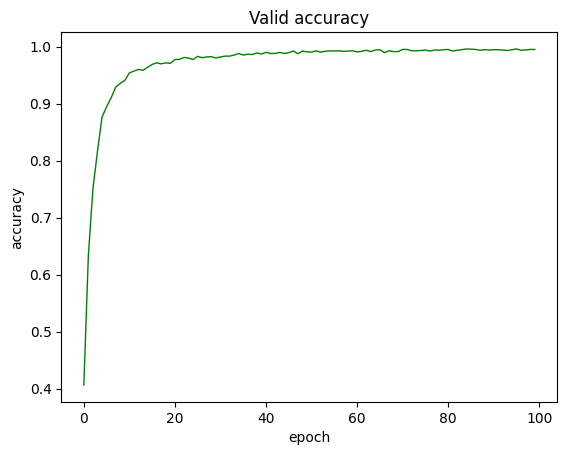

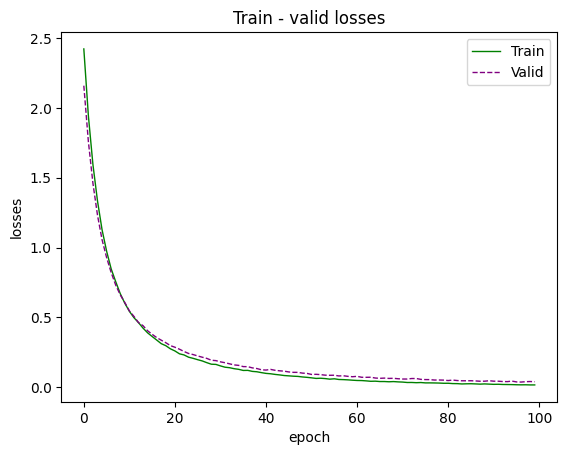

In [ ]:
visualize_accuracy(val_acc)
visualize_losses(train_losses, val_losses)

###RESNET50

In [ ]:
# Load Resnet50 model
resnet = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


In [ ]:
# Freeze layer 1-6 of Resnet50
resnet = freeze_layers(resnet, 6)

child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  5  was frozen
child  6  was frozen


In [ ]:
# Customize the final layer of Resnet50
resnet.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 14),
    nn.LogSoftmax(dim = 1)
)

In [ ]:
# Define Loss function
lossf = nn.NLLLoss()

In [ ]:
lr = 1e-5
epochs = 100
model, train_losses, val_losses, val_acc = train(resnet, train_loader, val_loader, lr = lr, epochs = epochs)

  1%|          | 1/100 [00:17<29:32, 17.90s/it]

 train_loss 2.3408; val_loss 1.9016; val_acc 0.4909


  2%|▏         | 2/100 [00:35<28:31, 17.46s/it]

 train_loss 1.3977; val_loss 0.9174; val_acc 0.8582


  3%|▎         | 3/100 [00:52<28:00, 17.32s/it]

 train_loss 0.5678; val_loss 0.2944; val_acc 0.9724


  4%|▍         | 4/100 [01:09<27:35, 17.24s/it]

 train_loss 0.1874; val_loss 0.1182; val_acc 0.9930


  5%|▌         | 5/100 [01:26<27:13, 17.19s/it]

 train_loss 0.0738; val_loss 0.0601; val_acc 0.9972


  6%|▌         | 6/100 [01:43<26:53, 17.17s/it]

 train_loss 0.0387; val_loss 0.0352; val_acc 0.9995


  7%|▋         | 7/100 [02:00<26:35, 17.16s/it]

 train_loss 0.0241; val_loss 0.0257; val_acc 0.9995


  8%|▊         | 8/100 [02:17<26:19, 17.17s/it]

 train_loss 0.0170; val_loss 0.0229; val_acc 0.9977


  9%|▉         | 9/100 [02:35<26:01, 17.16s/it]

 train_loss 0.0140; val_loss 0.0166; val_acc 0.9991


 10%|█         | 10/100 [02:52<25:43, 17.15s/it]

 train_loss 0.0105; val_loss 0.0113; val_acc 0.9995


 11%|█         | 11/100 [03:09<25:26, 17.16s/it]

 train_loss 0.0077; val_loss 0.0118; val_acc 0.9986


 12%|█▏        | 12/100 [03:26<25:08, 17.14s/it]

 train_loss 0.0063; val_loss 0.0124; val_acc 0.9991


 13%|█▎        | 13/100 [03:43<24:51, 17.14s/it]

 train_loss 0.0051; val_loss 0.0086; val_acc 0.9991


 14%|█▍        | 14/100 [04:00<24:34, 17.14s/it]

 train_loss 0.0057; val_loss 0.0102; val_acc 0.9981


 15%|█▌        | 15/100 [04:17<24:17, 17.15s/it]

 train_loss 0.0054; val_loss 0.0123; val_acc 0.9972


 16%|█▌        | 16/100 [04:35<24:00, 17.15s/it]

 train_loss 0.0039; val_loss 0.0061; val_acc 0.9991


 17%|█▋        | 17/100 [04:52<23:43, 17.15s/it]

 train_loss 0.0030; val_loss 0.0078; val_acc 0.9986


 18%|█▊        | 18/100 [05:09<23:26, 17.15s/it]

 train_loss 0.0028; val_loss 0.0041; val_acc 0.9995


 19%|█▉        | 19/100 [05:26<23:10, 17.16s/it]

 train_loss 0.0021; val_loss 0.0071; val_acc 0.9991


 20%|██        | 20/100 [05:43<22:52, 17.15s/it]

 train_loss 0.0018; val_loss 0.0061; val_acc 0.9991


 21%|██        | 21/100 [06:00<22:35, 17.16s/it]

 train_loss 0.0019; val_loss 0.0049; val_acc 0.9995


 22%|██▏       | 22/100 [06:17<22:18, 17.16s/it]

 train_loss 0.0016; val_loss 0.0060; val_acc 0.9986


 23%|██▎       | 23/100 [06:35<22:00, 17.15s/it]

 train_loss 0.0015; val_loss 0.0037; val_acc 0.9991


 24%|██▍       | 24/100 [06:52<21:43, 17.15s/it]

 train_loss 0.0013; val_loss 0.0031; val_acc 0.9995


 25%|██▌       | 25/100 [07:09<21:27, 17.16s/it]

 train_loss 0.0011; val_loss 0.0017; val_acc 1.0000


 26%|██▌       | 26/100 [07:26<21:10, 17.16s/it]

 train_loss 0.0011; val_loss 0.0035; val_acc 0.9995


 27%|██▋       | 27/100 [07:43<20:52, 17.16s/it]

 train_loss 0.0011; val_loss 0.0018; val_acc 1.0000


 28%|██▊       | 28/100 [08:00<20:35, 17.15s/it]

 train_loss 0.0010; val_loss 0.0036; val_acc 0.9991


 29%|██▉       | 29/100 [08:18<20:18, 17.16s/it]

 train_loss 0.0034; val_loss 0.0038; val_acc 0.9995


 30%|███       | 30/100 [08:35<20:01, 17.17s/it]

 train_loss 0.0036; val_loss 0.0034; val_acc 0.9991


 31%|███       | 31/100 [08:52<19:44, 17.16s/it]

 train_loss 0.0013; val_loss 0.0044; val_acc 0.9986


 32%|███▏      | 32/100 [09:09<19:26, 17.16s/it]

 train_loss 0.0011; val_loss 0.0051; val_acc 0.9991


 33%|███▎      | 33/100 [09:26<19:10, 17.16s/it]

 train_loss 0.0025; val_loss 0.0038; val_acc 0.9981


 34%|███▍      | 34/100 [09:43<18:52, 17.16s/it]

 train_loss 0.0010; val_loss 0.0019; val_acc 0.9995


 35%|███▌      | 35/100 [10:01<18:36, 17.17s/it]

 train_loss 0.0020; val_loss 0.0044; val_acc 0.9991


 36%|███▌      | 36/100 [10:18<18:18, 17.16s/it]

 train_loss 0.0015; val_loss 0.0038; val_acc 0.9991


 37%|███▋      | 37/100 [10:35<18:01, 17.17s/it]

 train_loss 0.0016; val_loss 0.0079; val_acc 0.9986


 38%|███▊      | 38/100 [10:52<17:43, 17.16s/it]

 train_loss 0.0007; val_loss 0.0033; val_acc 0.9995


 39%|███▉      | 39/100 [11:09<17:27, 17.16s/it]

 train_loss 0.0004; val_loss 0.0025; val_acc 0.9991


 40%|████      | 40/100 [11:26<17:08, 17.15s/it]

 train_loss 0.0004; val_loss 0.0049; val_acc 0.9991


 41%|████      | 41/100 [11:44<16:51, 17.15s/it]

 train_loss 0.0005; val_loss 0.0031; val_acc 0.9995


 42%|████▏     | 42/100 [12:01<16:34, 17.15s/it]

 train_loss 0.0006; val_loss 0.0067; val_acc 0.9986


 43%|████▎     | 43/100 [12:18<16:17, 17.14s/it]

 train_loss 0.0005; val_loss 0.0040; val_acc 0.9986


 44%|████▍     | 44/100 [12:35<15:59, 17.14s/it]

 train_loss 0.0004; val_loss 0.0069; val_acc 0.9981


 45%|████▌     | 45/100 [12:52<15:42, 17.15s/it]

 train_loss 0.0004; val_loss 0.0034; val_acc 0.9991


 46%|████▌     | 46/100 [13:09<15:25, 17.14s/it]

 train_loss 0.0004; val_loss 0.0032; val_acc 0.9991


 47%|████▋     | 47/100 [13:26<15:08, 17.14s/it]

 train_loss 0.0004; val_loss 0.0012; val_acc 1.0000


 48%|████▊     | 48/100 [13:43<14:51, 17.14s/it]

 train_loss 0.0003; val_loss 0.0018; val_acc 0.9995


 49%|████▉     | 49/100 [14:01<14:34, 17.15s/it]

 train_loss 0.0003; val_loss 0.0016; val_acc 0.9995


 50%|█████     | 50/100 [14:18<14:17, 17.14s/it]

 train_loss 0.0002; val_loss 0.0047; val_acc 0.9986


 51%|█████     | 51/100 [14:35<13:59, 17.14s/it]

 train_loss 0.0002; val_loss 0.0026; val_acc 0.9991


 52%|█████▏    | 52/100 [14:52<13:42, 17.14s/it]

 train_loss 0.0003; val_loss 0.0006; val_acc 1.0000


 53%|█████▎    | 53/100 [15:09<13:25, 17.14s/it]

 train_loss 0.0002; val_loss 0.0034; val_acc 0.9991


 54%|█████▍    | 54/100 [15:26<13:08, 17.14s/it]

 train_loss 0.0004; val_loss 0.0065; val_acc 0.9986


 55%|█████▌    | 55/100 [15:43<12:51, 17.13s/it]

 train_loss 0.0004; val_loss 0.0040; val_acc 0.9991


 56%|█████▌    | 56/100 [16:01<12:34, 17.14s/it]

 train_loss 0.0002; val_loss 0.0024; val_acc 0.9995


 57%|█████▋    | 57/100 [16:18<12:16, 17.14s/it]

 train_loss 0.0001; val_loss 0.0046; val_acc 0.9991


 58%|█████▊    | 58/100 [16:35<11:59, 17.14s/it]

 train_loss 0.0001; val_loss 0.0007; val_acc 1.0000


 59%|█████▉    | 59/100 [16:52<11:42, 17.14s/it]

 train_loss 0.0002; val_loss 0.0031; val_acc 0.9986


 60%|██████    | 60/100 [17:09<11:25, 17.14s/it]

 train_loss 0.0001; val_loss 0.0018; val_acc 0.9995


 61%|██████    | 61/100 [17:26<11:08, 17.14s/it]

 train_loss 0.0001; val_loss 0.0031; val_acc 0.9991


 62%|██████▏   | 62/100 [17:43<10:51, 17.15s/it]

 train_loss 0.0001; val_loss 0.0058; val_acc 0.9991


 63%|██████▎   | 63/100 [18:01<10:34, 17.14s/it]

 train_loss 0.0011; val_loss 0.0053; val_acc 0.9986


 64%|██████▍   | 64/100 [18:18<10:16, 17.14s/it]

 train_loss 0.0006; val_loss 0.0038; val_acc 0.9986


 65%|██████▌   | 65/100 [18:35<09:59, 17.13s/it]

 train_loss 0.0002; val_loss 0.0053; val_acc 0.9991


 66%|██████▌   | 66/100 [18:52<09:42, 17.13s/it]

 train_loss 0.0002; val_loss 0.0010; val_acc 0.9995


 67%|██████▋   | 67/100 [19:09<09:25, 17.14s/it]

 train_loss 0.0001; val_loss 0.0047; val_acc 0.9991


 68%|██████▊   | 68/100 [19:26<09:08, 17.14s/it]

 train_loss 0.0001; val_loss 0.0057; val_acc 0.9991


 69%|██████▉   | 69/100 [19:43<08:51, 17.15s/it]

 train_loss 0.0001; val_loss 0.0019; val_acc 0.9991


 70%|███████   | 70/100 [20:01<08:34, 17.14s/it]

 train_loss 0.0009; val_loss 0.0014; val_acc 0.9991


 71%|███████   | 71/100 [20:18<08:17, 17.15s/it]

 train_loss 0.0002; val_loss 0.0024; val_acc 0.9991


 72%|███████▏  | 72/100 [20:35<08:00, 17.15s/it]

 train_loss 0.0001; val_loss 0.0006; val_acc 1.0000


 73%|███████▎  | 73/100 [20:52<07:42, 17.14s/it]

 train_loss 0.0001; val_loss 0.0030; val_acc 0.9995


 74%|███████▍  | 74/100 [21:09<07:25, 17.15s/it]

 train_loss 0.0001; val_loss 0.0008; val_acc 1.0000


 75%|███████▌  | 75/100 [21:26<07:08, 17.14s/it]

 train_loss 0.0001; val_loss 0.0064; val_acc 0.9991


 76%|███████▌  | 76/100 [21:43<06:51, 17.13s/it]

 train_loss 0.0001; val_loss 0.0034; val_acc 0.9986


 77%|███████▋  | 77/100 [22:01<06:34, 17.13s/it]

 train_loss 0.0002; val_loss 0.0032; val_acc 0.9991


 78%|███████▊  | 78/100 [22:18<06:16, 17.13s/it]

 train_loss 0.0001; val_loss 0.0008; val_acc 0.9995


 79%|███████▉  | 79/100 [22:35<05:59, 17.14s/it]

 train_loss 0.0001; val_loss 0.0011; val_acc 0.9995


 80%|████████  | 80/100 [22:52<05:42, 17.13s/it]

 train_loss 0.0001; val_loss 0.0044; val_acc 0.9995


 81%|████████  | 81/100 [23:09<05:25, 17.13s/it]

 train_loss 0.0001; val_loss 0.0072; val_acc 0.9986


 82%|████████▏ | 82/100 [23:26<05:08, 17.14s/it]

 train_loss 0.0001; val_loss 0.0050; val_acc 0.9995


 83%|████████▎ | 83/100 [23:43<04:51, 17.14s/it]

 train_loss 0.0001; val_loss 0.0058; val_acc 0.9986


 84%|████████▍ | 84/100 [24:00<04:34, 17.14s/it]

 train_loss 0.0001; val_loss 0.0001; val_acc 1.0000


 85%|████████▌ | 85/100 [24:18<04:17, 17.15s/it]

 train_loss 0.0000; val_loss 0.0029; val_acc 0.9995


 86%|████████▌ | 86/100 [24:35<03:59, 17.14s/it]

 train_loss 0.0000; val_loss 0.0006; val_acc 0.9995


 87%|████████▋ | 87/100 [24:52<03:42, 17.14s/it]

 train_loss 0.0000; val_loss 0.0026; val_acc 0.9991


 88%|████████▊ | 88/100 [25:09<03:25, 17.14s/it]

 train_loss 0.0000; val_loss 0.0062; val_acc 0.9981


 89%|████████▉ | 89/100 [25:26<03:08, 17.14s/it]

 train_loss 0.0000; val_loss 0.0010; val_acc 0.9995


 90%|█████████ | 90/100 [25:43<02:51, 17.14s/it]

 train_loss 0.0000; val_loss 0.0005; val_acc 0.9995


 91%|█████████ | 91/100 [26:00<02:34, 17.14s/it]

 train_loss 0.0000; val_loss 0.0004; val_acc 0.9995


 92%|█████████▏| 92/100 [26:18<02:17, 17.14s/it]

 train_loss 0.0000; val_loss 0.0010; val_acc 0.9995


 93%|█████████▎| 93/100 [26:35<02:00, 17.15s/it]

 train_loss 0.0000; val_loss 0.0057; val_acc 0.9995


 94%|█████████▍| 94/100 [26:52<01:42, 17.15s/it]

 train_loss 0.0000; val_loss 0.0003; val_acc 1.0000


 95%|█████████▌| 95/100 [27:09<01:25, 17.15s/it]

 train_loss 0.0002; val_loss 0.0046; val_acc 0.9991


 96%|█████████▌| 96/100 [27:26<01:08, 17.14s/it]

 train_loss 0.0001; val_loss 0.0040; val_acc 0.9991


 97%|█████████▋| 97/100 [27:43<00:51, 17.14s/it]

 train_loss 0.0000; val_loss 0.0073; val_acc 0.9981


 98%|█████████▊| 98/100 [28:01<00:34, 17.15s/it]

 train_loss 0.0000; val_loss 0.0016; val_acc 0.9991


 99%|█████████▉| 99/100 [28:18<00:17, 17.15s/it]

 train_loss 0.0000; val_loss 0.0033; val_acc 0.9986


100%|██████████| 100/100 [28:35<00:00, 17.15s/it]

 train_loss 0.0000; val_loss 0.0031; val_acc 0.9991


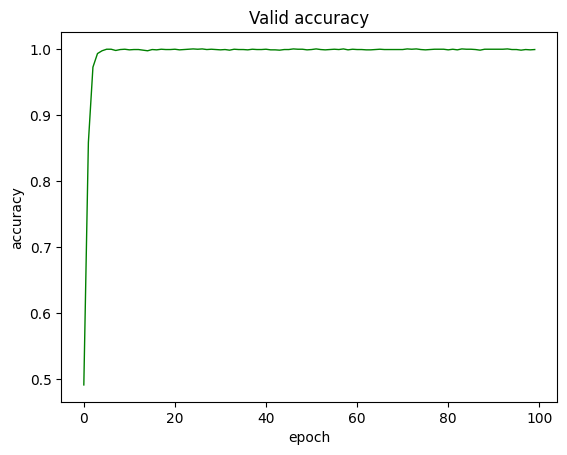

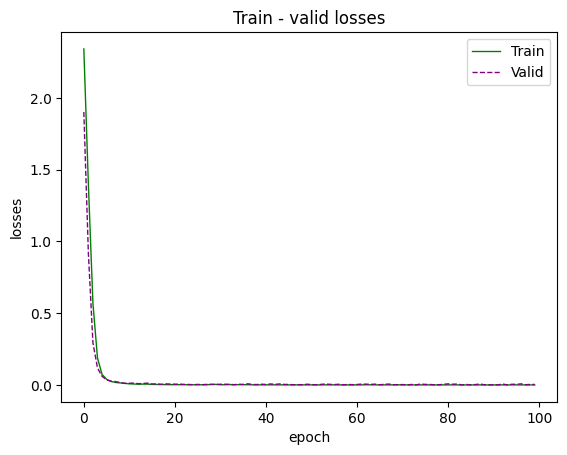

In [ ]:
visualize_accuracy(val_acc)
visualize_losses(train_losses, val_losses)

###VGG16

In [ ]:
# Load VGG16 model
vgg = models.vgg16(pretrained = True)

In [ ]:
# Freeze layers 1-2 of VGG16
vgg = freeze_layers(vgg, 2)

child  1  was frozen
child  2  was frozen


In [ ]:
# Customize the final layer
vgg.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.LeakyReLU(),
    nn.Dropout(0.4),
    nn.Linear(2048, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 14),
    nn.Softmax(dim = 1)
)

In [ ]:
# Define Loss Function
lossf = nn.CrossEntropyLoss()

In [ ]:
lr = 4e-5
epochs = 100
model, train_losses, val_losses, val_acc = train(vgg, train_loader, val_loader, lr = lr, epochs = epochs)

  1%|          | 1/100 [00:16<26:41, 16.17s/it]

 train_loss 2.2497; val_loss 1.9582; val_acc 0.8685


  2%|▏         | 2/100 [00:32<26:30, 16.23s/it]

 train_loss 1.8648; val_loss 1.8194; val_acc 0.9644


  3%|▎         | 3/100 [00:48<26:26, 16.35s/it]

 train_loss 1.8006; val_loss 1.7985; val_acc 0.9677


  4%|▍         | 4/100 [01:05<26:08, 16.33s/it]

 train_loss 1.7824; val_loss 1.7789; val_acc 0.9934


  5%|▌         | 5/100 [01:21<25:47, 16.29s/it]

 train_loss 1.7681; val_loss 1.7696; val_acc 0.9963


  6%|▌         | 6/100 [01:37<25:28, 16.26s/it]

 train_loss 1.7607; val_loss 1.7665; val_acc 0.9958


  7%|▋         | 7/100 [01:53<25:11, 16.25s/it]

 train_loss 1.7585; val_loss 1.7630; val_acc 0.9995


  8%|▊         | 8/100 [02:10<24:55, 16.26s/it]

 train_loss 1.7575; val_loss 1.7605; val_acc 0.9986


  9%|▉         | 9/100 [02:26<24:39, 16.25s/it]

 train_loss 1.7566; val_loss 1.7608; val_acc 0.9977


 10%|█         | 10/100 [02:42<24:22, 16.25s/it]

 train_loss 1.7560; val_loss 1.7593; val_acc 1.0000


 11%|█         | 11/100 [02:58<24:06, 16.25s/it]

 train_loss 1.7557; val_loss 1.7579; val_acc 0.9995


 12%|█▏        | 12/100 [03:15<23:49, 16.24s/it]

 train_loss 1.7556; val_loss 1.7585; val_acc 0.9991


 13%|█▎        | 13/100 [03:31<23:33, 16.25s/it]

 train_loss 1.7555; val_loss 1.7576; val_acc 1.0000


 14%|█▍        | 14/100 [03:47<23:17, 16.25s/it]

 train_loss 1.7553; val_loss 1.7576; val_acc 0.9991


 15%|█▌        | 15/100 [04:03<23:01, 16.25s/it]

 train_loss 1.7556; val_loss 1.7573; val_acc 1.0000


 16%|█▌        | 16/100 [04:20<22:45, 16.26s/it]

 train_loss 1.7554; val_loss 1.7572; val_acc 1.0000


 17%|█▋        | 17/100 [04:36<22:28, 16.25s/it]

 train_loss 1.7553; val_loss 1.7565; val_acc 1.0000


 18%|█▊        | 18/100 [04:52<22:11, 16.24s/it]

 train_loss 1.7555; val_loss 1.7577; val_acc 0.9991


 19%|█▉        | 19/100 [05:08<21:55, 16.24s/it]

 train_loss 1.7552; val_loss 1.7565; val_acc 1.0000


 20%|██        | 20/100 [05:25<21:39, 16.24s/it]

 train_loss 1.7552; val_loss 1.7564; val_acc 0.9995


 21%|██        | 21/100 [05:41<21:23, 16.24s/it]

 train_loss 1.7551; val_loss 1.7569; val_acc 1.0000


 22%|██▏       | 22/100 [05:57<21:06, 16.23s/it]

 train_loss 1.7551; val_loss 1.7562; val_acc 1.0000


 23%|██▎       | 23/100 [06:13<20:49, 16.23s/it]

 train_loss 1.7550; val_loss 1.7563; val_acc 0.9995


 24%|██▍       | 24/100 [06:30<20:33, 16.23s/it]

 train_loss 1.7550; val_loss 1.7569; val_acc 0.9986


 25%|██▌       | 25/100 [06:46<20:18, 16.24s/it]

 train_loss 1.7550; val_loss 1.7568; val_acc 0.9995


 26%|██▌       | 26/100 [07:02<20:02, 16.25s/it]

 train_loss 1.7549; val_loss 1.7563; val_acc 1.0000


 27%|██▋       | 27/100 [07:18<19:46, 16.25s/it]

 train_loss 1.7549; val_loss 1.7555; val_acc 1.0000


 28%|██▊       | 28/100 [07:35<19:30, 16.25s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 1.0000


 29%|██▉       | 29/100 [07:51<19:13, 16.25s/it]

 train_loss 1.7549; val_loss 1.7564; val_acc 1.0000


 30%|███       | 30/100 [08:07<18:57, 16.24s/it]

 train_loss 1.7549; val_loss 1.7559; val_acc 1.0000


 31%|███       | 31/100 [08:23<18:41, 16.25s/it]

 train_loss 1.7549; val_loss 1.7559; val_acc 1.0000


 32%|███▏      | 32/100 [08:40<18:24, 16.25s/it]

 train_loss 1.7549; val_loss 1.7560; val_acc 0.9995


 33%|███▎      | 33/100 [08:56<18:08, 16.24s/it]

 train_loss 1.7549; val_loss 1.7560; val_acc 1.0000


 34%|███▍      | 34/100 [09:12<17:51, 16.24s/it]

 train_loss 1.7549; val_loss 1.7560; val_acc 1.0000


 35%|███▌      | 35/100 [09:28<17:35, 16.24s/it]

 train_loss 1.7549; val_loss 1.7559; val_acc 1.0000


 36%|███▌      | 36/100 [09:44<17:19, 16.24s/it]

 train_loss 1.7549; val_loss 1.7556; val_acc 0.9995


 37%|███▋      | 37/100 [10:01<17:02, 16.24s/it]

 train_loss 1.7549; val_loss 1.7564; val_acc 0.9991


 38%|███▊      | 38/100 [10:17<16:46, 16.24s/it]

 train_loss 1.7549; val_loss 1.7598; val_acc 0.9958


 39%|███▉      | 39/100 [10:33<16:30, 16.24s/it]

 train_loss 1.7550; val_loss 1.7567; val_acc 0.9986


 40%|████      | 40/100 [10:49<16:14, 16.24s/it]

 train_loss 1.7562; val_loss 1.7736; val_acc 0.9869


 41%|████      | 41/100 [11:06<15:57, 16.23s/it]

 train_loss 1.7591; val_loss 1.7620; val_acc 0.9963


 42%|████▏     | 42/100 [11:22<15:41, 16.23s/it]

 train_loss 1.7564; val_loss 1.7724; val_acc 0.9855


 43%|████▎     | 43/100 [11:38<15:25, 16.23s/it]

 train_loss 1.7559; val_loss 1.7577; val_acc 0.9977


 44%|████▍     | 44/100 [11:54<15:08, 16.23s/it]

 train_loss 1.7556; val_loss 1.7561; val_acc 1.0000


 45%|████▌     | 45/100 [12:11<14:52, 16.23s/it]

 train_loss 1.7549; val_loss 1.7569; val_acc 0.9991


 46%|████▌     | 46/100 [12:27<14:36, 16.24s/it]

 train_loss 1.7550; val_loss 1.7558; val_acc 0.9995


 47%|████▋     | 47/100 [12:43<14:20, 16.23s/it]

 train_loss 1.7552; val_loss 1.7560; val_acc 0.9995


 48%|████▊     | 48/100 [12:59<14:04, 16.23s/it]

 train_loss 1.7549; val_loss 1.7566; val_acc 0.9986


 49%|████▉     | 49/100 [13:15<13:47, 16.23s/it]

 train_loss 1.7549; val_loss 1.7555; val_acc 0.9995


 50%|█████     | 50/100 [13:32<13:31, 16.23s/it]

 train_loss 1.7549; val_loss 1.7561; val_acc 0.9995


 51%|█████     | 51/100 [13:48<13:15, 16.24s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 0.9995


 52%|█████▏    | 52/100 [14:04<12:59, 16.24s/it]

 train_loss 1.7548; val_loss 1.7559; val_acc 0.9995


 53%|█████▎    | 53/100 [14:20<12:43, 16.24s/it]

 train_loss 1.7548; val_loss 1.7556; val_acc 1.0000


 54%|█████▍    | 54/100 [14:37<12:27, 16.25s/it]

 train_loss 1.7549; val_loss 1.7553; val_acc 0.9995


 55%|█████▌    | 55/100 [14:53<12:11, 16.25s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 0.9995


 56%|█████▌    | 56/100 [15:09<11:55, 16.25s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 57%|█████▋    | 57/100 [15:25<11:38, 16.25s/it]

 train_loss 1.7548; val_loss 1.7557; val_acc 0.9995


 58%|█████▊    | 58/100 [15:42<11:22, 16.25s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 59%|█████▉    | 59/100 [15:58<11:06, 16.25s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 60%|██████    | 60/100 [16:14<10:50, 16.25s/it]

 train_loss 1.7548; val_loss 1.7557; val_acc 0.9995


 61%|██████    | 61/100 [16:31<10:33, 16.25s/it]

 train_loss 1.7551; val_loss 1.7564; val_acc 0.9991


 62%|██████▏   | 62/100 [16:47<10:17, 16.25s/it]

 train_loss 1.7563; val_loss 1.7577; val_acc 0.9981


 63%|██████▎   | 63/100 [17:03<10:01, 16.25s/it]

 train_loss 1.7556; val_loss 1.7655; val_acc 0.9911


 64%|██████▍   | 64/100 [17:19<09:45, 16.25s/it]

 train_loss 1.7564; val_loss 1.7575; val_acc 0.9986


 65%|██████▌   | 65/100 [17:36<09:28, 16.25s/it]

 train_loss 1.7576; val_loss 1.7601; val_acc 0.9967


 66%|██████▌   | 66/100 [17:52<09:12, 16.25s/it]

 train_loss 1.7562; val_loss 1.7589; val_acc 0.9967


 67%|██████▋   | 67/100 [18:08<08:55, 16.24s/it]

 train_loss 1.7550; val_loss 1.7576; val_acc 0.9981


 68%|██████▊   | 68/100 [18:24<08:39, 16.24s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 0.9995


 69%|██████▉   | 69/100 [18:40<08:23, 16.23s/it]

 train_loss 1.7548; val_loss 1.7559; val_acc 0.9991


 70%|███████   | 70/100 [18:57<08:07, 16.23s/it]

 train_loss 1.7549; val_loss 1.7571; val_acc 0.9981


 71%|███████   | 71/100 [19:13<07:50, 16.23s/it]

 train_loss 1.7549; val_loss 1.7561; val_acc 0.9991


 72%|███████▏  | 72/100 [19:29<07:34, 16.23s/it]

 train_loss 1.7548; val_loss 1.7561; val_acc 0.9995


 73%|███████▎  | 73/100 [19:45<07:18, 16.23s/it]

 train_loss 1.7549; val_loss 1.7555; val_acc 0.9995


 74%|███████▍  | 74/100 [20:02<07:01, 16.23s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 0.9995


 75%|███████▌  | 75/100 [20:18<06:45, 16.23s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9995


 76%|███████▌  | 76/100 [20:34<06:29, 16.24s/it]

 train_loss 1.7549; val_loss 1.7563; val_acc 0.9986


 77%|███████▋  | 77/100 [20:50<06:13, 16.24s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 0.9995


 78%|███████▊  | 78/100 [21:07<05:57, 16.25s/it]

 train_loss 1.7548; val_loss 1.7561; val_acc 0.9986


 79%|███████▉  | 79/100 [21:23<05:41, 16.25s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 0.9995


 80%|████████  | 80/100 [21:39<05:25, 16.25s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9991


 81%|████████  | 81/100 [21:55<05:08, 16.26s/it]

 train_loss 1.7548; val_loss 1.7559; val_acc 0.9991


 82%|████████▏ | 82/100 [22:12<04:52, 16.26s/it]

 train_loss 1.7548; val_loss 1.7562; val_acc 0.9991


 83%|████████▎ | 83/100 [22:28<04:36, 16.26s/it]

 train_loss 1.7548; val_loss 1.7555; val_acc 0.9995


 84%|████████▍ | 84/100 [22:44<04:20, 16.26s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 1.0000


 85%|████████▌ | 85/100 [23:00<04:03, 16.26s/it]

 train_loss 1.7548; val_loss 1.7562; val_acc 0.9986


 86%|████████▌ | 86/100 [23:17<03:47, 16.26s/it]

 train_loss 1.7548; val_loss 1.7553; val_acc 1.0000


 87%|████████▋ | 87/100 [23:33<03:31, 16.26s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9991


 88%|████████▊ | 88/100 [23:49<03:14, 16.25s/it]

 train_loss 1.7548; val_loss 1.7560; val_acc 0.9991


 89%|████████▉ | 89/100 [24:05<02:58, 16.24s/it]

 train_loss 1.7548; val_loss 1.7555; val_acc 0.9995


 90%|█████████ | 90/100 [24:22<02:42, 16.25s/it]

 train_loss 1.7548; val_loss 1.7559; val_acc 0.9991


 91%|█████████ | 91/100 [24:38<02:26, 16.25s/it]

 train_loss 1.7548; val_loss 1.7550; val_acc 1.0000


 92%|█████████▏| 92/100 [24:54<02:09, 16.24s/it]

 train_loss 1.7548; val_loss 1.7551; val_acc 1.0000


 93%|█████████▎| 93/100 [25:10<01:53, 16.24s/it]

 train_loss 1.7548; val_loss 1.7551; val_acc 1.0000


 94%|█████████▍| 94/100 [25:27<01:37, 16.24s/it]

 train_loss 1.7548; val_loss 1.7555; val_acc 0.9995


 95%|█████████▌| 95/100 [25:43<01:21, 16.23s/it]

 train_loss 1.7548; val_loss 1.7553; val_acc 1.0000


 96%|█████████▌| 96/100 [25:59<01:04, 16.23s/it]

 train_loss 1.7548; val_loss 1.7553; val_acc 1.0000


 97%|█████████▋| 97/100 [26:15<00:48, 16.24s/it]

 train_loss 1.7548; val_loss 1.7557; val_acc 0.9995


 98%|█████████▊| 98/100 [26:32<00:32, 16.24s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9991


 99%|█████████▉| 99/100 [26:48<00:16, 16.24s/it]

 train_loss 1.7548; val_loss 1.7550; val_acc 1.0000


100%|██████████| 100/100 [27:04<00:00, 16.24s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 0.9995


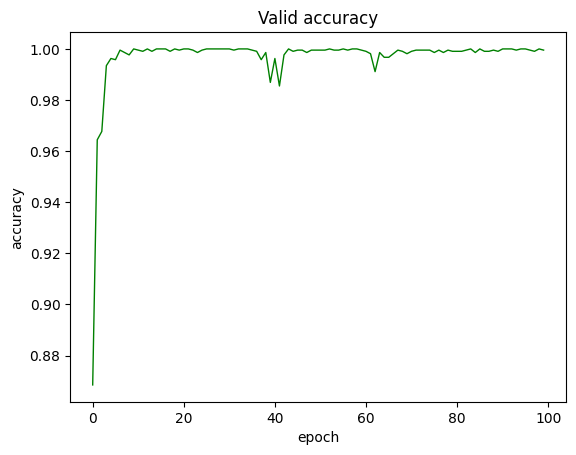

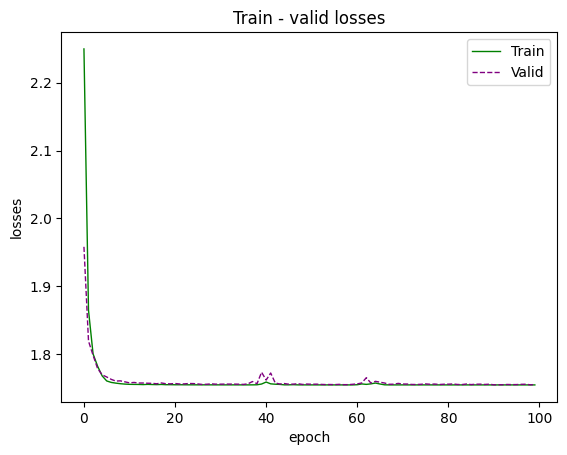

In [ ]:
visualize_accuracy(val_acc)
visualize_losses(train_losses, val_losses)

In [ ]:
torch.save(model, "model.pt")

In [ ]:
model_extraction = model
model_extraction.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.LeakyReLU()
)
model_extraction.to(device)

In [ ]:
embedding_list = []
name_encode_list = []

with torch.no_grad():
  for bi, (xi, yi) in enumerate(train_loader):
    emb = model_extraction(xi.to(device))
    yi = yi.type(torch.LongTensor) 
    yi = yi.to(device)

    for i in emb.tolist():
      embedding_list.append(torch.FloatTensor(i))
    for i in yi.tolist():
      name_encode_list.append(torch.FloatTensor(i))

### TEST CASE (WITH VGG)

In [ ]:
# Define test_case function
def test_case(picture_path):
  with torch.no_grad():
    cos = torch.nn.CosineSimilarity(dim=0)
    output_list = []
    img = Image.open(picture_path)
    face, prob = mtcnn(img, return_prob = True)
    if face is not None and prob > 0.90:

      # Cosine similarity
      face = face.to(device)
      face_emb = model_extraction(face.unsqueeze(0))

      for i in embedding_list:
        output = cos(face_emb[0], i.to(device)).item()
        output_list.append(output)

      max_output = max(output_list)
      print("Cosine similarity:", max_output)
      if max_output < 0.9:
        print("unrecognizable") 

      else:
        model = torch.load("model.pt")
        recognition = model(face.unsqueeze(0))
        recognition = recognition.argmax(dim = 1).long()
        name = label_encoder.inverse_transform(recognition.cpu())
        print(name[0])
    else:
      print("unrecognizable")

In [ ]:
picture_path = ""
test_case(picture_path)